In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Read main data to DataFrame
df = pd.read_stata('Cash_and_Childhood_Development_Replication/macoursetal_main.dta')  

# Income variables

In [4]:
df1=df[["hogarid_old","cp_old","unique_05","s1age_head_05","s1hhsize_05","s1hhsz_undr5_05","s1hhsz_5_14_05",
        "s1hhsz_15_24_05","s1hhsz_25_64_05","s1hhsz_65plus_05","s1male_head_05","s2mother_inhs_05","s3ap5_rooms_h_05",
        "s3ap23_stime_h_05","s3ap24_htime_h_05","s3ap25_hqtime_h_05","s3atoilet_hh_05","s3awater_access_hh_05",
        "s3aelectric_hh_05","s4p6_vitamina_i_05","s4p7_parasite_i_05","s11ownland_hh_05","cons_food_pc_05","cons_tot_pc_05",
        "tvip_05","height_05","a10whz_05","weight_05","itt_i","itt_all_i","yrsedfath","age_transfer","bweight",
        "s4p7_parasite_i_06","cpmom_06","T","male","TREAT1","TREAT2","TREAT3","TREAT4","ed_mom","MUN1","MUN2","MUN3","MUN4",
        "MUN5","MUN6","com_haz_05","com_waz_05","com_tvip_05","com_control_05","com_vit_05","com_deworm_05","com_notvip",
        "sample06","vitamiron_06",#"weighted_05",
        "propfood_05","prstap_f_05","pranimalprot_f_05","prfruitveg_f_05"]]

In [5]:
df1.rename(columns = {'T':'tr'}, inplace = True)

C:\Users\Usuari\AppData\Local\Temp\ipykernel_14028\2300806653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns = {'T':'tr'}, inplace = True)


In [6]:
#fem una copia del df
def copy_df(df):
   return df.copy()

In [7]:
#eliminem individus amb >delta*100% columnes buides
def drop_ind_missing(df, delta):
    thresh = len(df.columns)*delta
    df.dropna(axis=0, thresh=thresh, inplace=True)
    return df

In [8]:
#eliminem individus amb age transfer<age
def drop_out_missing(df, age=-11):
    nan_rows=df[df.age_transfer<age].index
    df.drop(nan_rows, inplace=True)
    return df

In [9]:
#categorical to ordinal
def ordinal(df, cols):
    enc = OrdinalEncoder()
    enc.fit(df[cols])
    df[cols] = enc.transform(df[cols])
    
    return df

In [10]:
#imputem NaNs

#imputem mitjanes
def mean_imputer(df, cols):
    for col in cols:
        df[col].fillna(df[col].mean(), inplace=True)
    return df

#imputem el valor més frequent de la columna dintre el hh
def hh_mf_imputer(df,cols):
    index=df.index
    for col in cols:
        col_hh=[df[df.hogarid_old==familia][[col,"age_transfer"]].sort_values(by=['age_transfer'])[col]
                .values for familia in df.hogarid_old]
        for i in range(len(index)):
               if np.isnan(df[col][index[i]]):
                    non_nan_len=np.count_nonzero(~np.isnan(col_hh[i]))
                    if(non_nan_len!=0):
                        vals,counts = np.unique(col_hh[i], return_counts=True)
                        ind = np.argmax(counts)
                        df.loc[index[i],col]=vals[ind]
    return df             
                            
                        

In [11]:
#eliminem outliers

def outlier_removal(df,cols):
    outlier_threshold = []
    for col in cols:
            q3 = np.nanpercentile(df[col], 75)
            q1 = np.nanpercentile(df[col], 25)
            iqr = q3 - q1
            out_low = q1 - 1.5*iqr
            out_high = q3 + 1.5*iqr
            outlier_threshold.append([out_low, out_high])
    outliers_indexs=[]
    for col,k in zip(cols,range(len(cols))):
        #outliers_indexs_in_col=[]
        for i in range(len(df[col])):
            if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
                outliers_indexs.append(i)
        #outliers_indexs.append(outliers_indexs_in_col)
    print(len(list(set(outliers_indexs))))
    return df.drop(list(set(outliers_indexs)), axis=0)

In [12]:
def normalize(df, cols):
    Nscaler = MinMaxScaler()

    Nscaler.fit(df[cols])
    df[cols] = Nscaler.transform(df[cols])
    
    return df

def standardize(df, cols):
    Sscaler = StandardScaler()

    Sscaler.fit(df[cols])
    df[cols] = Sscaler.transform(df[cols])
    
    return df

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

mean_cols=["bweight", "tvip_05", "height_05", "a10whz_05", "weight_05"]
hh_mf_cols=["s1age_head_05","s1hhsize_05","s1hhsz_undr5_05","s1hhsz_5_14_05","s1hhsz_15_24_05","s1hhsz_25_64_05",
            "s1hhsz_65plus_05","s1male_head_05","s2mother_inhs_05","s3ap5_rooms_h_05","s3atoilet_hh_05",
            "s3awater_access_hh_05","s3aelectric_hh_05","s11ownland_hh_05","s4p7_parasite_i_06","ed_mom","vitamiron_06",
           "s4p6_vitamina_i_05", "s4p7_parasite_i_05", "cons_food_pc_05", "yrsedfath", "propfood_05", "prstap_f_05"
            ,  "pranimalprot_f_05",  "prfruitveg_f_05"]

normal_cols =["height_05","a10whz_05","weight_05","com_haz_05","com_waz_05"]

Nnormal_cols = ['s1age_head_05', 's3ap23_stime_h_05', 's3ap24_htime_h_05', 's3ap25_hqtime_h_05', 'cons_food_pc_05', 
                'cons_tot_pc_05', 'tvip_05', 'yrsedfath','age_transfer', 'bweight', 'ed_mom', 'com_tvip_05', 'com_control_05']

categorical_cols=df1.select_dtypes(exclude=["number","bool_","object_"]).columns

cleaned_df=(df1.pipe(copy_df)
            .pipe(drop_ind_missing, 0.8)
            .pipe(drop_out_missing)
            .pipe(ordinal, categorical_cols)
            .pipe(hh_mf_imputer, hh_mf_cols)
            .pipe(mean_imputer, mean_cols+hh_mf_cols))
            #.pipe(outlier_removal)) #outliers
            #.pipe(standardize, normal_cols) #estandaritzacio
            #.pipe(normalize, Nnormal_cols)) #normalitzacio
                         

KeyboardInterrupt: 

In [14]:
prova=(df1.pipe(copy_df)
            .pipe(drop_ind_missing, 0.8)
            .pipe(drop_out_missing)
            .pipe(ordinal, categorical_cols))
df=prova
outlier_threshold = []
cols=df.columns
for col in cols:
    q3 = np.nanpercentile(df[col], 75)
    q1 = np.nanpercentile(df[col], 25)
    iqr = q3 - q1
    out_low = q1 - 3*iqr
    out_high = q3 + 3*iqr
    outlier_threshold.append([out_low, out_high])
outliers_indexs=[]

series_values=[]
for col,k in zip(cols,range(len(cols))):
    outliers_indexs_in_col=[]
    for i in df[col].index:
        if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
            outliers_indexs.append(i)
            outliers_indexs_in_col.append(i)
    #outliers_indexs.append(outliers_indexs_in_col)
    series_values.append(len(outliers_indexs_in_col))

outliers=pd.Series(series_values,index=df.columns)

In [17]:
outliers=outliers[outliers!=[0]*len(outliers)].sort_values()

In [18]:
len (outliers)

33

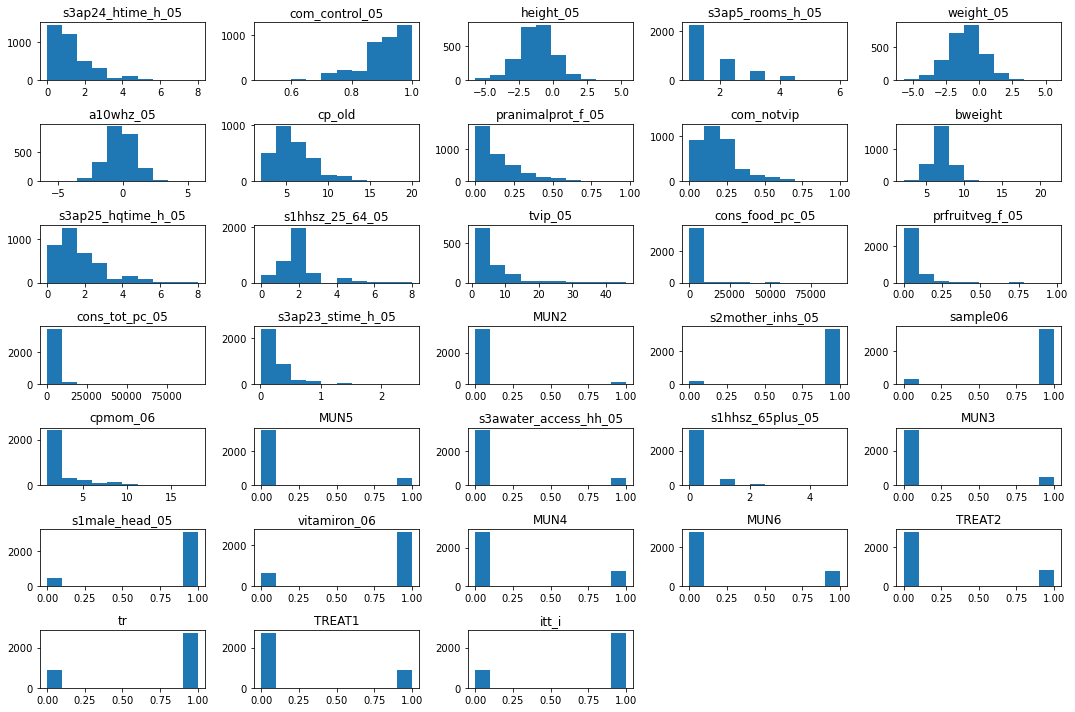

In [19]:
plt.figure(figsize=(15,10))
for col,i in zip(outliers.index,range(len(outliers))):
    plt.subplot(7,5,i+1)
    plt.hist(df[col])
    plt.title(col)
plt.tight_layout()

In [20]:
outlier_cols=['s3ap24_htime_h_05', 'com_control_05', 'height_05',
       'weight_05', 'a10whz_05', 'pranimalprot_f_05', 'com_notvip',
       'bweight', 's3ap25_hqtime_h_05', 's1hhsz_25_64_05', 'tvip_05',
       'cons_food_pc_05', 'prfruitveg_f_05', 's3ap23_stime_h_05',
       'cons_tot_pc_05']

In [65]:
prova=(df1.pipe(copy_df)
            .pipe(drop_ind_missing, 0.8)
            .pipe(drop_out_missing)
            .pipe(ordinal, categorical_cols))
df=prova
outlier_threshold = []
minmax=[]
cols=outlier_cols
for col in cols:
    q3 = np.nanpercentile(df[col], 75)
    q1 = np.nanpercentile(df[col], 25)
    iqr = q3 - q1
    out_low = q1 - 3*iqr
    out_high = q3 + 3*iqr
    outlier_threshold.append([out_low, out_high])
    minmax.append([np.min(df[col]), np.max(df[col])])
outliers_indexs=[]

series_values=[]
for col,k in zip(cols,range(len(cols))):
    outliers_indexs_in_col=[]
    for i in df[col].index:
        if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
            outliers_indexs.append(i)
            outliers_indexs_in_col.append(i)
    #outliers_indexs.append(outliers_indexs_in_col)
    series_values.append(len(outliers_indexs_in_col))

outliers=pd.Series(series_values,index=cols)
threshold=pd.Series(outlier_threshold,index=cols)

In [66]:
number_outliers=outliers[outliers!=[0]*len(outliers)].sort_values()
number_outliers

s3ap24_htime_h_05      2
com_control_05         3
height_05              3
weight_05              4
a10whz_05              5
pranimalprot_f_05      8
com_notvip            14
bweight               29
s3ap25_hqtime_h_05    30
s1hhsz_25_64_05       35
tvip_05               38
cons_food_pc_05       48
prfruitveg_f_05       49
s3ap23_stime_h_05     60
cons_tot_pc_05        60
dtype: int64

In [67]:
threshold

s3ap24_htime_h_05                                    [-4.0, 6.5]
com_control_05          [0.5777777433395386, 1.2518519163131714]
height_05                 [-6.74676051735878, 4.330846786499023]
weight_05               [-6.7076223492622375, 4.682587027549744]
a10whz_05              [-5.0658362954854965, 4.7107314467430115]
pranimalprot_f_05       [-0.510146863758564, 0.7757952567189932]
com_notvip            [-0.37962964177131653, 0.7222222313284874]
bweight                                              [1.5, 12.0]
s3ap25_hqtime_h_05      [-2.6666667461395264, 5.500000059604645]
s1hhsz_25_64_05                                      [-2.0, 5.0]
tvip_05                                            [-13.0, 22.0]
cons_food_pc_05           [-3431.77099609375, 8475.628051757812]
prfruitveg_f_05       [-0.1885903044603765, 0.26803941756952554]
s3ap23_stime_h_05      [-0.6666666865348816, 1.0833333656191826]
cons_tot_pc_05          [-5576.202880859375, 13036.261779785156]
dtype: object

In [98]:
#thresholds proposats per en Joel a través de la seva exploració d'outliers
joelthreshold=["No tocar","No tocar","No tocar","No tocar","No tocar"
               ,[0,0.6], [0,0.99],[1.5,10],"[0,6] o no tocar","[0,7] o no tocar","No tocar","No tocar",[0,0.6],"No tocar","Cagada"]

In [72]:
df_threshold=threshold.to_frame(name="IQR*3 treshold")
df_threshold["var range"]=minmax
df_threshold["Joel threshold"]=joelthreshold
df_threshold["n_outliers(IQR*3)"]=number_outliers.values

In [73]:
df_threshold

,IQR*3 treshold,var range,Joel threshold,n_outliers(IQR*3)
s3ap24_htime_h_05,"[-4.0, 6.5]","[0.0, 8.0]",No tocar,2
com_control_05,"[0.5777777433395386, 1.2518519163131714]","[0.5, 1.0]",No tocar,3
height_05,"[-6.74676051735878, 4.330846786499023]","[-5.690308094024658, 5.357271194458008]",No tocar,3
weight_05,"[-6.7076223492622375, 4.682587027549744]","[-5.692336082458496, 5.628351211547852]",No tocar,4
a10whz_05,"[-5.0658362954854965, 4.7107314467430115]","[-5.823857307434082, 5.777897834777832]",No tocar,5
pranimalprot_f_05,"[-0.510146863758564, 0.7757952567189932]","[0.0, 0.9717028141021729]","[0, 0.6]",8
com_notvip,"[-0.37962964177131653, 0.7222222313284874]","[0.0, 1.0]","[0, 0.99]",14
bweight,"[1.5, 12.0]","[2.0, 21.779998779296875]","[1.5, 10]",29
s3ap25_hqtime_h_05,"[-2.6666667461395264, 5.500000059604645]","[0.0, 8.0]","[0,6] o no tocar",30
s1hhsz_25_64_05,"[-2.0, 5.0]","[0.0, 8.0]","[0,7] o no tocar",35


Provem un mix entre en Joel i el nostre alg...

In [81]:
outlier_cols=['pranimalprot_f_05', 'com_notvip',
       'bweight', 'prfruitveg_f_05']

In [89]:
prova=(df1.pipe(copy_df)
            .pipe(drop_ind_missing, 0.8)
            .pipe(drop_out_missing)
            .pipe(ordinal, categorical_cols))
df=prova
outlier_threshold = []
minmax=[]
cols=outlier_cols
for col in cols:
    q3 = np.nanpercentile(df[col], 75)
    q1 = np.nanpercentile(df[col], 25)
    iqr = q3 - q1
    out_low = q1 - 3*iqr
    out_high = q3 + 3*iqr
    outlier_threshold.append([out_low, out_high])
    minmax.append([np.min(df[col]), np.max(df[col])])
outliers_indexs=[]

series_values=[]
for col,k in zip(cols,range(len(cols))):
    outliers_indexs_in_col=[]
    for i in df[col].index:
        if df[col][i]<outlier_threshold[k][0] or df[col][i]>outlier_threshold[k][1]:
            outliers_indexs.append(i)
            outliers_indexs_in_col.append(i)
    #outliers_indexs.append(outliers_indexs_in_col)
    series_values.append(len(outliers_indexs_in_col))

outliers=pd.Series(series_values,index=cols)
threshold=pd.Series(outlier_threshold,index=cols)

In [90]:
number_outliers=outliers[outliers!=[0]*len(outliers)].sort_values()
number_outliers

pranimalprot_f_05     8
com_notvip           14
bweight              29
prfruitveg_f_05      49
dtype: int64

In [97]:
df[df.prfruitveg_f_05>0.268].describe()

,hogarid_old,cp_old,unique_05,s1age_head_05,s1hhsize_05,s1hhsz_undr5_05,s1hhsz_5_14_05,s1hhsz_15_24_05,s1hhsz_25_64_05,s1hhsz_65plus_05,...,com_control_05,com_vit_05,com_deworm_05,com_notvip,sample06,vitamiron_06,propfood_05,prstap_f_05,pranimalprot_f_05,prfruitveg_f_05
count,4.900000e+01,38.000000,4.900000e+01,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,...,49.000000,49.000000,49.000000,49.000000,49.000000,47.000000,48.000000,49.000000,49.000000,49.000000
mean,7.016392e+07,5.605263,2.237051e+06,38.714287,5.591837,1.428571,1.306122,1.040816,1.591837,0.204082,...,0.931175,0.733590,0.488900,0.209353,0.959184,0.744681,0.677426,0.348090,0.099528,0.388525
std,1.080590e+05,2.520612,3.392947e+05,17.678846,2.668633,0.889757,1.357143,0.956538,0.998297,0.407205,...,0.042432,0.157873,0.135579,0.116062,0.199915,0.440755,0.188580,0.133167,0.085729,0.137421
min,7.005570e+07,3.000000,2.035749e+06,19.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.857143,0.368421,0.176471,0.000000,0.000000,0.000000,0.244505,0.016611,0.000000,0.269028
25%,7.006460e+07,3.000000,2.040712e+06,26.000000,3.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.911765,0.640000,0.428571,0.166667,1.000000,0.500000,0.568069,0.236025,0.032022,0.310287
50%,7.015110e+07,5.000000,2.045727e+06,31.000000,5.000000,1.000000,1.000000,1.000000,2.000000,0.000000,...,0.918367,0.739130,0.500000,0.200000,1.000000,1.000000,0.707993,0.334221,0.071053,0.350178
75%,7.024760e+07,7.750000,2.505744e+06,52.000000,7.000000,2.000000,2.000000,2.000000,2.000000,0.000000,...,0.960000,0.861111,0.531250,0.300000,1.000000,1.000000,0.816583,0.460816,0.161563,0.404363
max,7.043920e+07,11.000000,3.015709e+06,71.000000,11.000000,3.000000,4.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,0.857143,0.473684,1.000000,1.000000,0.985816,0.581274,0.297090,0.980038


In [95]:
df.describe()

,hogarid_old,cp_old,unique_05,s1age_head_05,s1hhsize_05,s1hhsz_undr5_05,s1hhsz_5_14_05,s1hhsz_15_24_05,s1hhsz_25_64_05,s1hhsz_65plus_05,...,com_control_05,com_vit_05,com_deworm_05,com_notvip,sample06,vitamiron_06,propfood_05,prstap_f_05,pranimalprot_f_05,prfruitveg_f_05
count,3.620000e+03,2826.000000,3.620000e+03,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,...,3620.000000,3620.000000,3620.000000,3620.000000,3620.000000,3311.000000,3497.000000,3608.000000,3608.000000,3608.000000
mean,7.026760e+07,5.842534,2.327378e+06,41.488079,6.442265,1.356906,1.806354,1.208840,1.898619,0.148895,...,0.904771,0.689845,0.529116,0.192336,0.917680,0.806403,0.694613,0.594827,0.152958,0.052189
std,1.259714e+05,2.517403,3.581666e+05,14.863159,2.899775,0.802548,1.556103,1.286541,1.056015,0.433699,...,0.081183,0.182292,0.151088,0.129366,0.274888,0.395175,0.145907,0.182776,0.149443,0.066469
min,7.005310e+07,2.000000,2.035700e+06,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095726,0.000000,0.000000,0.000000
25%,7.016148e+07,4.000000,2.040712e+06,29.000000,4.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.866667,0.551020,0.428571,0.092593,1.000000,1.000000,0.609654,0.469747,0.040971,0.007108
50%,7.026675e+07,5.000000,2.045730e+06,38.000000,6.000000,1.000000,2.000000,1.000000,2.000000,0.000000,...,0.918367,0.705882,0.531250,0.176471,1.000000,1.000000,0.716088,0.608794,0.109115,0.033092
75%,7.037793e+07,7.000000,2.505771e+06,51.000000,8.000000,2.000000,3.000000,2.000000,2.000000,0.000000,...,0.962963,0.854167,0.629630,0.250000,1.000000,1.000000,0.801730,0.731716,0.224677,0.072341
max,7.049010e+07,20.000000,3.015730e+06,97.000000,20.000000,5.000000,9.000000,7.000000,8.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.990492,0.995946,0.971703,0.980038
